This guide shows a potential issue with the resonance generation keeping isomorphic and identical benzene structures.
This was generated using the `reactBenzenes` branch on Feb 16 2017.

In [1]:
from rmgpy.species import Species
from rmgpy.molecule import Molecule, Atom, Bond

In [2]:
benzene = Molecule().fromSMILES('c1ccccc1')
benzene.assignAtomIndices()
resStruc = benzene.generateResonanceIsomers(keepIsomorphic=True)

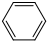

In [3]:
resStruc[0]

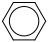

In [4]:
resStruc[1]

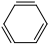

In [5]:
resStruc[2]

In [6]:
resStruc[0].isIsomorphic(resStruc[2])

True

In [7]:
resStruc[0].isIdentical(resStruc[2])

False

The previous line returns a non-deterministic result. I run it below 100 times and show the variation

In [8]:
isIdenticalList = []
for i in range(100):
    resStruc = benzene.generateResonanceIsomers(keepIsomorphic=True)
    identical = resStruc[0].isIdentical(resStruc[2])
    isIdenticalList.append(identical)
print 'The resonance structures are identical {} times'.format(isIdenticalList.count(True))
print 'The resonance structures are NOT identical {} times'.format(isIdenticalList.count(False))

The resonance structures are identical 54 times
The resonance structures are NOT identical 46 times
